# Evolutionary algorithms

### Encoding
Create a method for the representation of a solution to a particular problem. THis should be such that when varying this encoding it should not change much. E.g. changing a decimal instead of flipping a binary bit

### Parent selection
Neutral selection: Draw parents uniformly at random \
Fitness-proportional / Roulette wheel selection: Draw individuals with probability proportional to their fitness. \
Tournament selection: Randomly select k individuals for a "tournament group"
and pick the best one (according to fitness value).

### Variation
Mutation -> change one parent bt a small amount localy
Recombination / Crossover -> combine the two parents into offspring

### Surbibal selection
$(\mu, \lambda)$-selection -> select $\mu$ from the set of offsprings where $(\lambda \ge \mu)$ \
$(\mu + \lambda)$-selection -> Select $\mu$ best individuals from set of $\mu$ parents and $\lambda$ offsprings

Advantages
- Simple but enough to solve complex problems
- All parameter types possible in general
- Highly parallelizable
- Flexible through different variation operations

Disadvantages
- Little mathematical rigor (for realistic, complex EAs)
- Hard to find balance between exploration and exploitation
- Quite some parameters, hard to determine them
- Customization necessary for complex problems

Not suitable for expensive problems like HPO as large number of
function evaluations necessary


## Evolution of balls

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image as IPImage
import imageio
from PIL import Image
import os

np.random.seed(121)

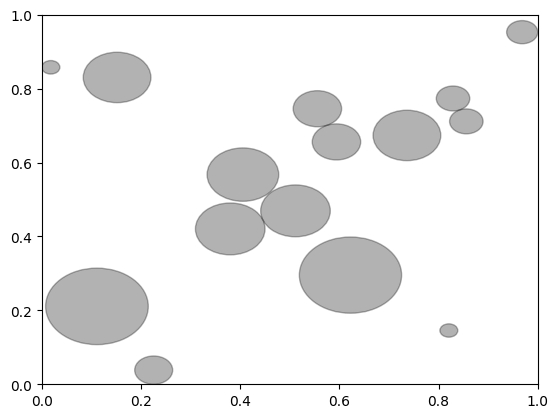

In [26]:
def distance_between(a, b):
    dist = (a[0] - b[0])**2 + (a[1] - b[1])**2
    return np.sqrt(dist)

# Problem
n = 15
inital_grid = np.random.rand(n,3)

for i, circle in enumerate(inital_grid):
    if circle[2] > min(circle[0], circle[1], 1 - circle[0], 1 - circle[1]):
        circle[2] = min(circle[0], circle[1], 1 - circle[0], 1 - circle[1])

    for other_circle in inital_grid[i + 1:]:
        dist = distance_between(circle[0:2], other_circle[0:2])
        if dist < circle[2] + other_circle[2]:
            other_circle[2] = min(dist / 2, other_circle[2])
            circle[2] = min(dist / 2, circle[2]) 

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

for circle in inital_grid:
    circle_shape = plt.Circle((circle[0], circle[1]), circle[2], color='black', fill=True, alpha=0.3)
    ax.add_patch(circle_shape)
plt.show()

Make inital poputlation and scoring function

In [27]:
def score(X, grid):
    scores = []
    for x in X:
        score = min(x[0], x[1], 1 - x[0], 1 - x[1])               

        for circle in grid:
            score = min(max(distance_between(x,circle) - circle[2],0), score)

        scores.append(score)
    scores = np.reshape(np.array(scores), (1,len(scores)))

    return np.concatenate((X, scores.T), axis=1)

In [28]:
def fitness_selection(scored_values, n):
    return scored_values[scored_values[:, 2].argsort()[::-1]][0:n][:, :2]

def fitness_selection_probabilistic(scored_values, n):
    probabilities = scored_values[:, 2]
    probabilities /= probabilities.sum()  # Normalize probabilities
    selected_indices = np.random.choice(len(scored_values), size=n, p=probabilities)
    selected_elements = scored_values[selected_indices, :2]
    return selected_elements


Here we are getting the selected parrents from the new population and futher selecting 2 at random multiple times. Following this, if, by chance, they reach the crossover probability, then they will be combined (average).

In [29]:
def crossover(population, crossover_prob):
    new_population = []
    pop_size = len(population)
    
    for _ in range(pop_size // 2):
        parent1, parent2 = population[np.random.choice(pop_size, 2, replace=False)]
        
        if np.random.rand() <= crossover_prob:
            # Simple crossover: averaging for one child, swap genes for the other
            child1 = (parent1 + parent2) / 2
            child2 = [parent1[0], parent2[1]]  # 1st from parent1, 2nd from parent2
        else:
            # No crossover: children are copies of parents
            child1, child2 = parent1.copy(), parent2.copy()

        new_population.append(child1)
        new_population.append(child2)

    # If the population size is odd, add one random individual from the original population
    if pop_size % 2 != 0:
        new_population.append(population[np.random.choice(pop_size)])

    return np.array(new_population)

Uniform mutation: Select random gene xj and replace it by uniformly distributed
value (within feasible range).
Gauss mutation: x ± N (0, σI)
Polynomial mutation: Use a different distribution instead of normal distribution


In [30]:
def mutation(population, mutation_prob, mutationStepSize):
    new_population = []

    for parent in population:

        if np.random.rand() <= mutation_prob:
            # Apply mutation by adding normal noise to both genes (x, y)
            mutation_noise = np.random.normal(0, mutationStepSize, 2)
            mutated_parent = parent + mutation_noise
            new_population.append(mutated_parent)
        else:
            # No mutation, add the parent unchanged
            new_population.append(parent.copy())

    return np.array(new_population)


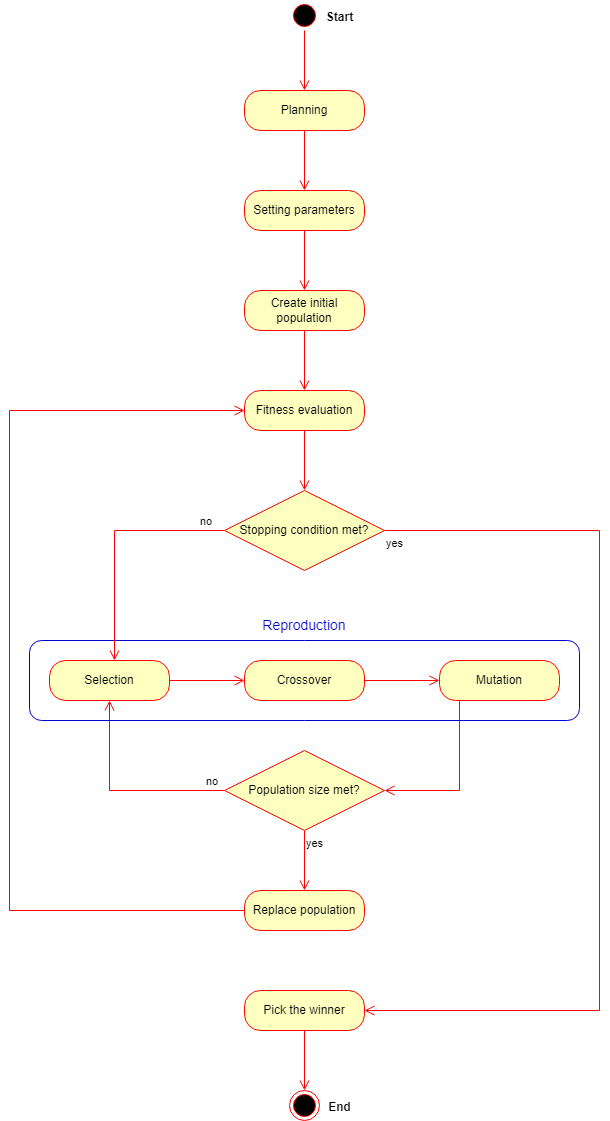

In [31]:
p = 20
mutation_prob = 0.8 
mutationStepSize = 0.1
crossover_prob = 0.8
generations = 30

n_parents = 6

In [32]:
def plot_circles(scored_pop, grid=inital_grid):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for circle in grid:
        circle_shape = plt.Circle((circle[0], circle[1]), circle[2], color='black', fill=True, alpha=0.3)
        ax.add_patch(circle_shape)

    for circle in scored_pop:
        circle_shape = plt.Circle((circle[0], circle[1]), circle[2], color='blue', fill=True, alpha=0.2)
        ax.add_patch(circle_shape)

    plt.show()

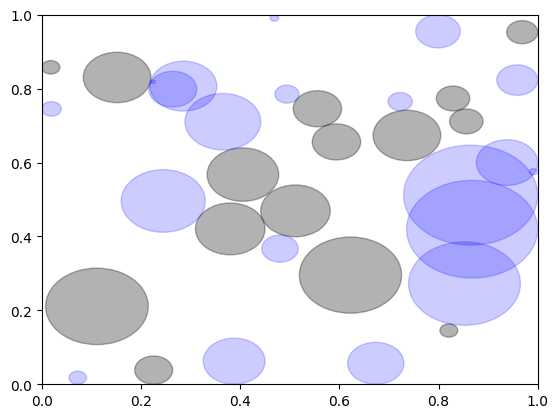

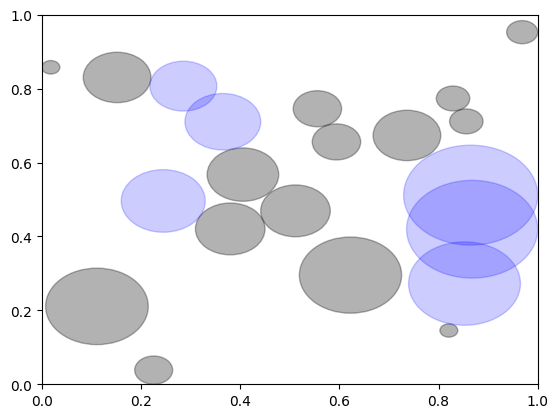

In [33]:
population = np.random.rand(p,2)
plot_circles(score(population, inital_grid))
plot_circles(score(fitness_selection(score(population, inital_grid), n_parents), inital_grid))

In [34]:
# Initialize population (assuming it already exists)
pop_history = []

for i in range(generations):
    evaluated_pop = score(population, inital_grid)
    new_parents = fitness_selection(evaluated_pop, n_parents) #picking top 6 
    
    # Perform crossover on the selected parents
    new_offspring = crossover(new_parents, crossover_prob)

    # Apply mutation to the new offspring
    new_offspring = mutation(new_offspring, mutation_prob, mutationStepSize)
    
    # Store a copy of the current population in history
    pop_history.append(population.copy())
    
    population = np.concatenate((new_parents, new_offspring), axis=0)

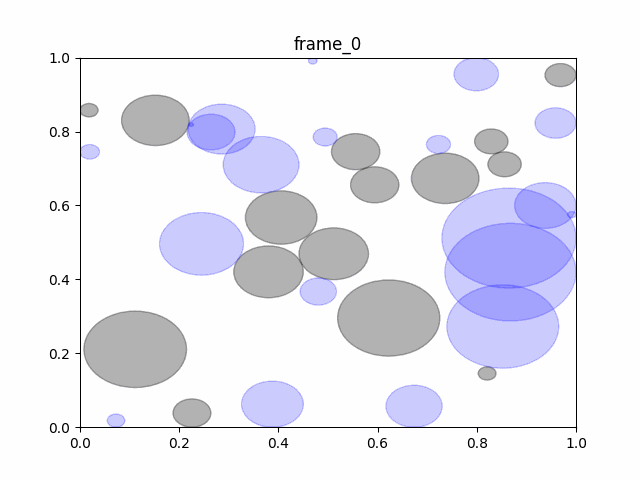

In [35]:
filenames = []

def save_frame(scored_pop, filename, grid=inital_grid):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for circle in grid:
        circle_shape = plt.Circle((circle[0], circle[1]), circle[2], color='black', fill=True, alpha=0.3)
        ax.add_patch(circle_shape)

    for circle in scored_pop:
        circle_shape = plt.Circle((circle[0], circle[1]), circle[2], color='blue', fill=True, alpha=0.2)
        ax.add_patch(circle_shape)

    t = filename.rstrip(".png")
    plt.title(f"{t}")

    plt.savefig(filename)
    plt.close()

# Create the plots and save them as images
for i, pop in enumerate(pop_history):
    filename = f"frame_{i}.png"
    save_frame(score(pop, inital_grid), filename)


    filenames.append(filename)

gif_filename = 'output.gif'
images = [Image.open(img_file) for img_file in filenames]
imageio.mimsave(gif_filename, images, duration=400, loop=0) 
display(IPImage(filename=gif_filename))


for filename in filenames:
    os.remove(filename)

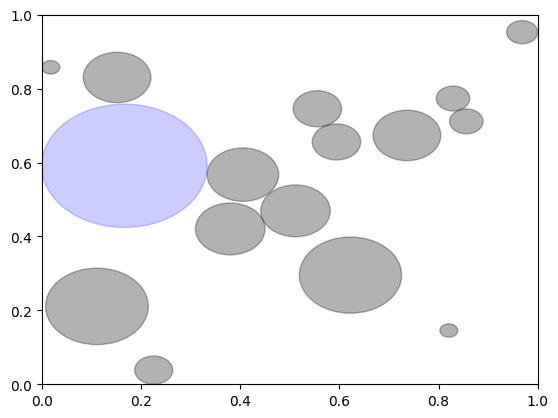

In [36]:
scored = score(population, inital_grid)
plot_circles(scored[scored[:, 2].argsort()[::-1]][0:1])